# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, IntegerType, BooleanType
from pyspark.sql.functions import desc, asc, udf, col, isnan, count, when, col, desc, col, sort_array, asc, avg, max
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import Window
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, NaiveBayes, RandomForestClassifier
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Project") \
    .getOrCreate()

In [3]:
sparkify_event_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_event_data)
df_cleaned = df.dropna(how = "any", subset = ["gender"])
df.count(), df_cleaned.count()

(286500, 278154)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## Features derived from `gender`

In [4]:
df_gender = df_cleaned.select('userId','gender').distinct()\
                        .withColumn('is_male', (df_cleaned.gender == 'M').cast(IntegerType()))\
                        .sort('userId')\
                        .select('userId','is_male')

In [5]:
#df_gender.show(5)

## Features derived from `page`

In [6]:
# One hot encode all distinct page values and put in the count per page per userId as feature

# create list of pages
pages = [row[0] for row in df_cleaned.select('page').distinct().collect()]
# remove cancellation events
pages.remove('Cancel')
pages.remove('Cancellation Confirmation')
print(pages)

windowval = Window.partitionBy('userId')

df_page = df_cleaned

# remove spaces in column names, fill column with 1 if page equals list value
for page in pages:
    df_page = df_page.withColumn(page.replace(' ', ''), 
                                       Fsum((df_cleaned.page == page).cast(IntegerType())).over(windowval))

# 2nd list for df.select 
pages_2 = []

for page in pages:
    pages_2.append(page.replace(' ',''))

# select subset of df and drop duplicates 
df_page = df_page.select('userId', *pages_2).dropDuplicates().sort('userId')

['Submit Downgrade', 'Thumbs Down', 'Home', 'Downgrade', 'Roll Advert', 'Logout', 'Save Settings', 'About', 'Settings', 'Add to Playlist', 'Add Friend', 'NextSong', 'Thumbs Up', 'Help', 'Upgrade', 'Error', 'Submit Upgrade']


In [7]:
#df_page_pd = df_page.toPandas()
#df_page_pd.head()

## Features derived from `itemInSession`, `sessionId` and `song`
We go for the average count of songs listened per session per user and the total count of songs listened here.

In [8]:
df_songs = df_cleaned.select('userId', 'sessionId','itemInSession') \
                            .groupby('userId', 'sessionId') \
                            .agg({'itemInSession':'max'}) \
                            .groupby('userId') \
                            .agg( Fsum('max(itemInSession)'), avg('max(itemInSession)'), count('sessionId') ) \
                            .withColumnRenamed('avg(max(itemInSession))','avg_count_songs_session') \
                            .withColumnRenamed('sum(max(itemInSession))','count_songs') \
                            .withColumnRenamed('count(sessionId)','count_sessions') \
                            .sort('userId')

In [9]:
#%%time
#print('Cell execution started', datetime.datetime.now())
#df_songs.show(5)
#print('Cell execution ended', datetime.datetime.now())

## Features derived from `registration` and `ts`
Get lifetime in days.

In [10]:
df_lt = df_cleaned.groupby('userId') \
            .agg({'registration' : 'min','ts':'max'})\
            .withColumn('lt_in_days',(col('max(ts)')-col('min(registration)'))/1000/60/60/24)\
            .select('userId','lt_in_days')\
            .sort('userId')

In [11]:
#%%time
#df_lt.show(5)

## Features derived from `status`
one hot encode count of the 3 statuses

In [12]:
# create list of status
status_list = [str(row[0]) for row in df_cleaned.select('status').distinct().collect()]
print(status_list)

['307', '404', '200']


In [13]:
df_status = df_cleaned

# remove spaces in column names, fill column with 1 if page equals list value
for status in status_list:
    df_status = df_status.withColumn('status_'+status, 
                                       Fsum((df_cleaned.status == status).cast(IntegerType())).over(windowval))

df_status = df_status.select('userId','status_307','status_404','status_200').distinct().sort('userId')

In [14]:
#%%time
#df_status.show(5)

## Features derived from `userAgent`

In [15]:
lov = ['Macintosh', 'Windows NT', 'X11', 'iPad', 'iPhone', 'MSIE']

df_user_agent = df_cleaned
 
@udf
def map_userAgents(row_value):
    for value in lov:
        if row_value.find(value) > -1:
            return(value)

# remove spaces in column names, fill column with 1 if userAgent contains list value
df_user_agent = df_user_agent.select('userId','userAgent')\
                            .distinct()\
                            .withColumn('userAgent_short', map_userAgents(col('userAgent')))\
                            .select('userId','userAgent_short')

for value in lov:
    df_user_agent = df_user_agent.withColumn(value.replace(' ', ''), (col('userAgent_short') == value).cast(IntegerType()))

# 2nd list for df.select 
lov_2 = []

for value in lov:
    lov_2.append(value.replace(' ',''))

#select subset of df and drop duplicates 
df_user_agent = df_user_agent.select('userId', *lov_2)

In [16]:
#%%time
#print('Cell execution started', datetime.datetime.now())
#df_user_agent.show(5)
#print('Cell execution ended', datetime.datetime.now())

## Features derived from `level`

In [17]:
df_level = df_cleaned.select('userId','level').distinct()\
                        .withColumn('user_level_paid', (df_cleaned.level == 'paid').cast(IntegerType()))\
                        .groupby('userId')\
                        .agg({'user_level_paid':'max'})\
                        .select('userId','max(user_level_paid)')\
                        .withColumnRenamed('max(user_level_paid)','hasPaid')\
                        .sort('userId')

In [18]:
#%%time
#df_level.show(6)

## Some Data Cleansing & Preparation

In [19]:
# create df_label with labels for churn
tag_event_cancelation = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df_labels = df_cleaned.withColumn('event_cancelation', tag_event_cancelation(df_cleaned["page"]))
df_labels = df_labels.withColumn('label', Fsum('event_cancelation').over(windowval))
df_labels = df_labels.select('userId', 'label').dropDuplicates().sort('userId')

In [20]:
df_labels.select('label').distinct().show()
df_labels.show(2)

+-----+
|label|
+-----+
|    0|
|    1|
+-----+

+------+-----+
|userId|label|
+------+-----+
|    10|    0|
|   100|    0|
+------+-----+
only showing top 2 rows



In [21]:
# join all feature dfs together 
# .join(df_user_agent, "userId")\

df_full = df_labels.select('userId', 'label')\
                    .dropDuplicates()\
                    .join(df_gender, "userId")\
                    .join(df_level, "userId")\
                    .join(df_lt, "userId")\
                    .join(df_page, "userId")\
                    .join(df_songs, "userId")\
                    .join(df_status, "userId")\
                    .dropDuplicates()\
                    .sort('userId')

In [22]:
%%time
print('Cell execution started', datetime.datetime.now())
df_full.show(5)
print('Cell execution ended', datetime.datetime.now())

Cell execution started 2019-06-07 21:38:32.457633
+------+-----+-------+-------+------------------+---------------+----------+----+---------+----------+------+------------+-----+--------+-------------+---------+--------+--------+----+-------+-----+-------------+-----------+-----------------------+--------------+----------+----------+----------+
|userId|label|is_male|hasPaid|        lt_in_days|SubmitDowngrade|ThumbsDown|Home|Downgrade|RollAdvert|Logout|SaveSettings|About|Settings|AddtoPlaylist|AddFriend|NextSong|ThumbsUp|Help|Upgrade|Error|SubmitUpgrade|count_songs|avg_count_songs_session|count_sessions|status_307|status_404|status_200|
+------+-----+-------+-------+------------------+---------------+----------+----+---------+----------+------+------------+-----+--------+-------------+---------+--------+--------+----+-------+-----+-------------+-----------+-----------------------+--------------+----------+----------+----------+
|    10|    0|      1|      1| 51.76265046296296|          

In [23]:
df_full.toPandas().head(3)

,userId,label,is_male,hasPaid,lt_in_days,SubmitDowngrade,ThumbsDown,Home,Downgrade,RollAdvert,...,Help,Upgrade,Error,SubmitUpgrade,count_songs,avg_count_songs_session,count_sessions,status_307,status_404,status_200
0,10,0,1,1,51.762650,0,4,30,7,1,...,1,0,0,0,813,135.500000,6,65,0,730
1,100,0,1,1,64.873773,1,27,105,30,25,...,18,1,3,1,3263,93.228571,35,266,3,2945
2,100001,1,0,0,44.800220,0,2,11,0,14,...,1,2,1,0,197,49.250000,4,20,1,166


In [24]:
features = list(df_full.columns)
print(features)
type(features)
features.remove('userId')
features.remove('label')
print(features)

['userId', 'label', 'is_male', 'hasPaid', 'lt_in_days', 'SubmitDowngrade', 'ThumbsDown', 'Home', 'Downgrade', 'RollAdvert', 'Logout', 'SaveSettings', 'About', 'Settings', 'AddtoPlaylist', 'AddFriend', 'NextSong', 'ThumbsUp', 'Help', 'Upgrade', 'Error', 'SubmitUpgrade', 'count_songs', 'avg_count_songs_session', 'count_sessions', 'status_307', 'status_404', 'status_200']
['is_male', 'hasPaid', 'lt_in_days', 'SubmitDowngrade', 'ThumbsDown', 'Home', 'Downgrade', 'RollAdvert', 'Logout', 'SaveSettings', 'About', 'Settings', 'AddtoPlaylist', 'AddFriend', 'NextSong', 'ThumbsUp', 'Help', 'Upgrade', 'Error', 'SubmitUpgrade', 'count_songs', 'avg_count_songs_session', 'count_sessions', 'status_307', 'status_404', 'status_200']


## Put it all together in a function

In [25]:
def create_feature_df(df):
    print('Drop NaN values...')
    df_cleaned = df.dropna(how = "any", subset = ["gender"])
    
    print("Creating features from 'gender'...")
    df_gender = df_cleaned.select('userId','gender').distinct()\
                        .withColumn('is_male', (df_cleaned.gender == 'M').cast(IntegerType()))\
                        .sort('userId')\
                        .select('userId','is_male')
    
    print("Creating features from 'page'...")
    pages = [row[0] for row in df_cleaned.select('page').distinct().collect()]

    pages.remove('Cancel')
    pages.remove('Cancellation Confirmation')
    windowval = Window.partitionBy('userId')
    df_page = df_cleaned
    
    for page in pages:
        df_page = df_page.withColumn(page.replace(' ', ''),
                                     Fsum((df_cleaned.page == page).cast(IntegerType())).over(windowval))
    pages_2 = []
    for page in pages:
        pages_2.append(page.replace(' ',''))

    df_page = df_page.select('userId', *pages_2).dropDuplicates().sort('userId')
    
    print("Creating features from 'itemInSession' and 'sessionId'...")
    df_songs = df_cleaned.select('userId', 'sessionId','itemInSession') \
                            .groupby('userId', 'sessionId') \
                            .agg({'itemInSession':'max'}) \
                            .groupby('userId') \
                            .agg( Fsum('max(itemInSession)'), avg('max(itemInSession)'), count('sessionId') ) \
                            .withColumnRenamed('avg(max(itemInSession))','avg_count_songs_session') \
                            .withColumnRenamed('sum(max(itemInSession))','count_songs') \
                            .withColumnRenamed('count(sessionId)','count_sessions') \
                            .sort('userId')
    
    print("Creating features from 'registration' and 'ts'...")
    df_lt = df_cleaned.groupby('userId') \
            .agg({'registration' : 'min','ts':'max'})\
            .withColumn('lt_in_days',(col('max(ts)')-col('min(registration)'))/1000/60/60/24)\
            .select('userId','lt_in_days')\
            .sort('userId')

    print("Creating features from 'registration' and 'ts'...")
    status_list = [str(row[0]) for row in df_cleaned.select('status').distinct().collect()]
    df_status = df_cleaned
    for status in status_list:
        df_status = df_status.withColumn('status_'+status,
                                         Fsum((df_cleaned.status == status).cast(IntegerType())).over(windowval))
    df_status = df_status.select('userId','status_307','status_404','status_200').distinct().sort('userId')
    
    print("Creating features from 'level'...")
    df_level = df_cleaned.select('userId','level').distinct()\
                        .withColumn('user_level_paid', (df_cleaned.level == 'paid').cast(IntegerType()))\
                        .groupby('userId')\
                        .agg({'user_level_paid':'max'})\
                        .select('userId','max(user_level_paid)')\
                        .withColumnRenamed('max(user_level_paid)','hasPaid')\
                        .sort('userId')

    print("Creating labels...")
    tag_event_cancelation = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
    df_labels = df_cleaned.withColumn('event_cancelation', tag_event_cancelation(df_cleaned["page"]))
    df_labels = df_labels.withColumn('label', Fsum('event_cancelation').over(windowval))
    df_labels = df_labels.select('userId', 'label').dropDuplicates().sort('userId')
    
    print("Joining all df together to df_features...")
    df_features = df_labels.select('userId', 'label')\
                    .dropDuplicates()\
                    .join(df_gender, "userId")\
                    .join(df_level, "userId")\
                    .join(df_lt, "userId")\
                    .join(df_page, "userId")\
                    .join(df_songs, "userId")\
                    .join(df_status, "userId")\
                    .dropDuplicates()\
                    .sort('userId')
    
    print("Returned df_features...")
    return df_features

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### 1. Train Test Split, Vectorassembler and Standardscaler

In [26]:
%%time
# Apply vectorassembler - https://spark.apache.org/docs/latest/ml-features.html#vectorassembler
assembler = VectorAssembler(inputCols=features, outputCol='features_vector')

df_full = assembler.transform(df_full)

Wall time: 401 ms


In [27]:
print(features)

['is_male', 'hasPaid', 'lt_in_days', 'SubmitDowngrade', 'ThumbsDown', 'Home', 'Downgrade', 'RollAdvert', 'Logout', 'SaveSettings', 'About', 'Settings', 'AddtoPlaylist', 'AddFriend', 'NextSong', 'ThumbsUp', 'Help', 'Upgrade', 'Error', 'SubmitUpgrade', 'count_songs', 'avg_count_songs_session', 'count_sessions', 'status_307', 'status_404', 'status_200']


In [28]:
%%time
standardScaler = StandardScaler(inputCol='features_vector', 
                                outputCol='features_scaled')
scaler = standardScaler.fit(df_full)
df_scaled = scaler.transform(df_full)

Wall time: 2min 14s


In [29]:
train, test = df_scaled.randomSplit([0.8, 0.2], seed=42)

### 2. Fit and evaluate models (F1 Score)
#### 2.1 Function for evaluation metrics
https://spark.apache.org/docs/latest/mllib-evaluation-metrics.html

In [30]:
#MulticlassClassificationEvaluator??

In [31]:
def print_evaluation_metrics(predictionAndLabels):
    eval_f1 = MulticlassClassificationEvaluator(metricName='f1')
    eval_acc = MulticlassClassificationEvaluator(metricName='accuracy')
    eval_prc = MulticlassClassificationEvaluator(metricName='weightedPrecision')
    eval_rec = MulticlassClassificationEvaluator(metricName='weightedRecall')

    f1s = eval_f1.evaluate(predictionAndLabels.select(col('label'), col('prediction')))
    acc = eval_acc.evaluate(predictionAndLabels.select(col('label'), col('prediction')))
    prc = eval_prc.evaluate(predictionAndLabels.select(col('label'), col('prediction')))
    rec = eval_rec.evaluate(predictionAndLabels.select(col('label'), col('prediction')))
    
    print('f1 score:', f1s)
    print('accuracy:', acc)
    print('precision:', prc)
    print('recall:', rec)

#### 2.2 Logistic Regression
https://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression
https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.classification.LogisticRegression

In [32]:
#LogisticRegression??

In [33]:
%%time
print('Cell execution started', datetime.datetime.now())

lr = LogisticRegression(featuresCol='features_scaled', 
                        labelCol='label',
                        maxIter=5)
model_lr = lr.fit(train)
preds_lr = model_lr.transform(test)

print('Cell execution ended', datetime.datetime.now())

Cell execution started 2019-06-07 21:45:15.398257
Cell execution ended 2019-06-07 21:53:50.473338
Wall time: 8min 35s


In [34]:
%%time
print('Cell execution started', datetime.datetime.now())
print_evaluation_metrics(preds_lr)

Cell execution started 2019-06-07 21:53:50.487347
f1 score: 0.7650053022269353
accuracy: 0.8260869565217391
precision: 0.8570048309178744
recall: 0.8260869565217391
Wall time: 8min 38s


#### 2.2 Naive Bayes
https://spark.apache.org/docs/latest/ml-classification-regression.html#naive-bayes

In [35]:
#NaiveBayes??

In [36]:
%%time
nb = NaiveBayes(featuresCol='features_scaled', 
                labelCol='label')
model_nb = nb.fit(train) 
preds_nb = model_nb.transform(test)

Wall time: 6min 16s


In [37]:
%%time
print('Cell execution started', datetime.datetime.now())
print_evaluation_metrics(preds_nb)

Cell execution started 2019-06-07 22:08:45.840113
f1 score: 0.7416149068322981
accuracy: 0.7608695652173914
precision: 0.7288043478260868
recall: 0.7608695652173912
Wall time: 8min 48s


#### 2.3 Random forest classifier
https://spark.apache.org/docs/2.2.0/ml-classification-regression.html#random-forest-classifier

In [38]:
%%time
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol='label', 
                            featuresCol='features_scaled',
                            numTrees=10,
                            seed=42)
model_rf = rf.fit(train)
preds_rf = model_rf.transform(test)

Wall time: 6min 52s


In [39]:
%%time
print('Cell execution started', datetime.datetime.now())
print_evaluation_metrics(preds_rf)

Cell execution started 2019-06-07 22:24:26.915990
f1 score: 0.7826086956521738
accuracy: 0.782608695652174
precision: 0.7826086956521738
recall: 0.7826086956521738
Wall time: 9min 25s


### 3. Tune best model
Our best model here is the RandomForestClassifier, so lets look at the paramters to tune.

In [40]:
#RandomForestClassifier??

defaults from documentation:
```python
'maxDepth=5', 'maxBins=32', 'minInstancesPerNode=1', 'minInfoGain=0.0', 'maxMemoryInMB=256', 'cacheNodeIds=False', 'checkpointInterval=10', "impurity='gini'", 'numTrees=20', "featureSubsetStrategy='auto'", 'seed=None', 'subsamplingRate=1.0'```

In [41]:
# set up Crossvalidator and parameter grid for tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth,[1, 3, 10]) \
    .addGrid(rf.maxBins,[8, 16]) \
    .build()

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3)

In [42]:
%%time
print('Cell execution started', datetime.datetime.now())
cvModel = crossval.fit(train)
print('Cell execution ended', datetime.datetime.now())

Cell execution started 2019-06-07 22:33:52.173206
Cell execution ended 2019-06-07 23:05:02.457298
Wall time: 31min 10s


In [43]:
cvModel.avgMetrics

[0.6554818061511773,
 0.6554818061511773,
 0.6939496629809999,
 0.713253331784369,
 0.6988993410030286,
 0.7379383713483441]

In [44]:
cvModel.bestModel

RandomForestClassificationModel (uid=RandomForestClassifier_67284ec99b24) with 10 trees

In [45]:
cvModel.bestModel.featureImportances

SparseVector(26, {0: 0.012, 1: 0.0161, 2: 0.2186, 3: 0.041, 4: 0.0289, 5: 0.029, 6: 0.0263, 7: 0.0596, 8: 0.0155, 9: 0.0405, 10: 0.012, 11: 0.048, 12: 0.0407, 13: 0.0863, 14: 0.0252, 15: 0.0259, 16: 0.0449, 17: 0.0625, 18: 0.0017, 19: 0.0023, 20: 0.0144, 21: 0.0616, 22: 0.0417, 23: 0.0263, 24: 0.0052, 25: 0.0137})

In [46]:
feature_importances = pd.DataFrame(cvModel.bestModel.featureImportances.toArray(),
                                   index = features,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [47]:
feature_importances

,importance
lt_in_days,0.218604
AddFriend,0.086346
Upgrade,0.062534
avg_count_songs_session,0.061589
RollAdvert,0.059649
Settings,0.047999
Help,0.044903
count_sessions,0.041670
SubmitDowngrade,0.040991
AddtoPlaylist,0.040695


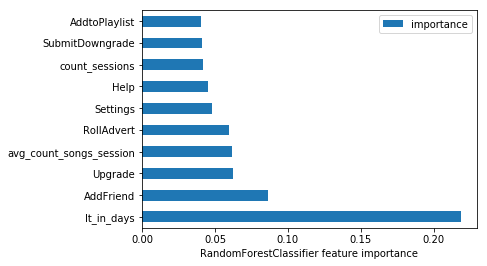

In [48]:
#show top 10 features
feature_importances.iloc[:10,:].plot(kind='barh');
plt.xlabel('RandomForestClassifier feature importance');

# Conclusion

### I. Load and clean the dataset
The small dataset has been loaded and cleaned successfully. The data cleansing was mainly related to visitor events that could not be linked to users with a specific userId.
Therefore, we cannot use these events for our training dataset and dropped them.

### II. Define the label/user churn
Churn has been defined as the 'Cancellation Confirmation' event and labeled accordingly in the dataset.

### III. Exploratory Data Analysis
Several plots have been created in order to analyze the dataset and gather knowledge and insights for the feature engineering part.

### IV. Feature Engineering
The features have been created accordingly to the previous analysis, could be further developed after model evaluation.

### V. Train models and tune the best model
3 ML classifiers have been trained and observed with regards to the F1 Score: LogisticRegression, NaiveBayes and RandomForestClassifier. As we have a small dataset with a binary label class which is imbalanced (one label proportion is significantly higher than the other) and has fewer positive labels (which is usually also the case for fraud detection) I decided to go for the F1 Score.

**RandomForestClassifier was the best model with F1 Score of 0.78 (LR 0.77, NB 0.74).** CrossValidator was applied afterwards, but did not lead to an improved F1 Score. So for further optimisation we can exclude the parameters:
```python
maxDepth - [1, 3, 10]
maxBins - [8, 16]
```

### VI. Suggested Improvements
I could train the model on the full dataset on a cloud server instance (AWS or IBM Watson), engineer a few more different features, use more combinations on the paramgrid for the CrossValidator and try out different classifiers.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [50]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Feature_Engineering_and_Model_Training.ipynb'])

0